time window = 2023-11-24 .. 2024-07-26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


2024-05-16, AMZN, close: 183.63,  rsi: 50.44, rsi-ma: 55.66, position: 0.00, pnl-pct: 0.00%
2024-05-16, MSFT, close: 420.99,  rsi: 58.31, rsi-ma: 50.52, position: 0.00, pnl-pct: 0.00%
2024-05-16, AAPL, close: 189.84,  rsi: 70.94, rsi-ma: 56.73, position: 0.00, pnl-pct: 0.00%
2024-05-16, GOOG, close: 175.43,  rsi: 68.09, rsi-ma: 63.18, position: 0.00, pnl-pct: 0.00%
2024-05-16, NVDA, close:  94.36,  rsi: 61.69, rsi-ma: 55.19, position: 0.00, pnl-pct: 0.00%
2024-05-16, META, close: 473.23,  rsi: 49.74, rsi-ma: 47.87, position: 0.00, pnl-pct: 0.00%
2024-05-17, AMZN, close:  184.7,  rsi: 52.33, rsi-ma: 55.42, position: 0.00, pnl-pct: 0.00%
2024-05-17, MSFT, close: 420.21,  rsi: 57.49, rsi-ma: 51.02, position: 0.00, pnl-pct: 0.00%
2024-05-17, AAPL, close: 189.87,  rsi: 70.97, rsi-ma: 57.75, position: 0.00, pnl-pct: 0.00%
2024-05-17, GOOG, close: 177.29,  rsi: 70.15, rsi-ma: 63.67, position: 0.00, pnl-pct: 0.00%
2024-05-17, NVDA, close:  92.48,  rsi: 57.47, rsi-ma: 55.36, position: 0.00, pnl

<IPython.core.display.Javascript object>

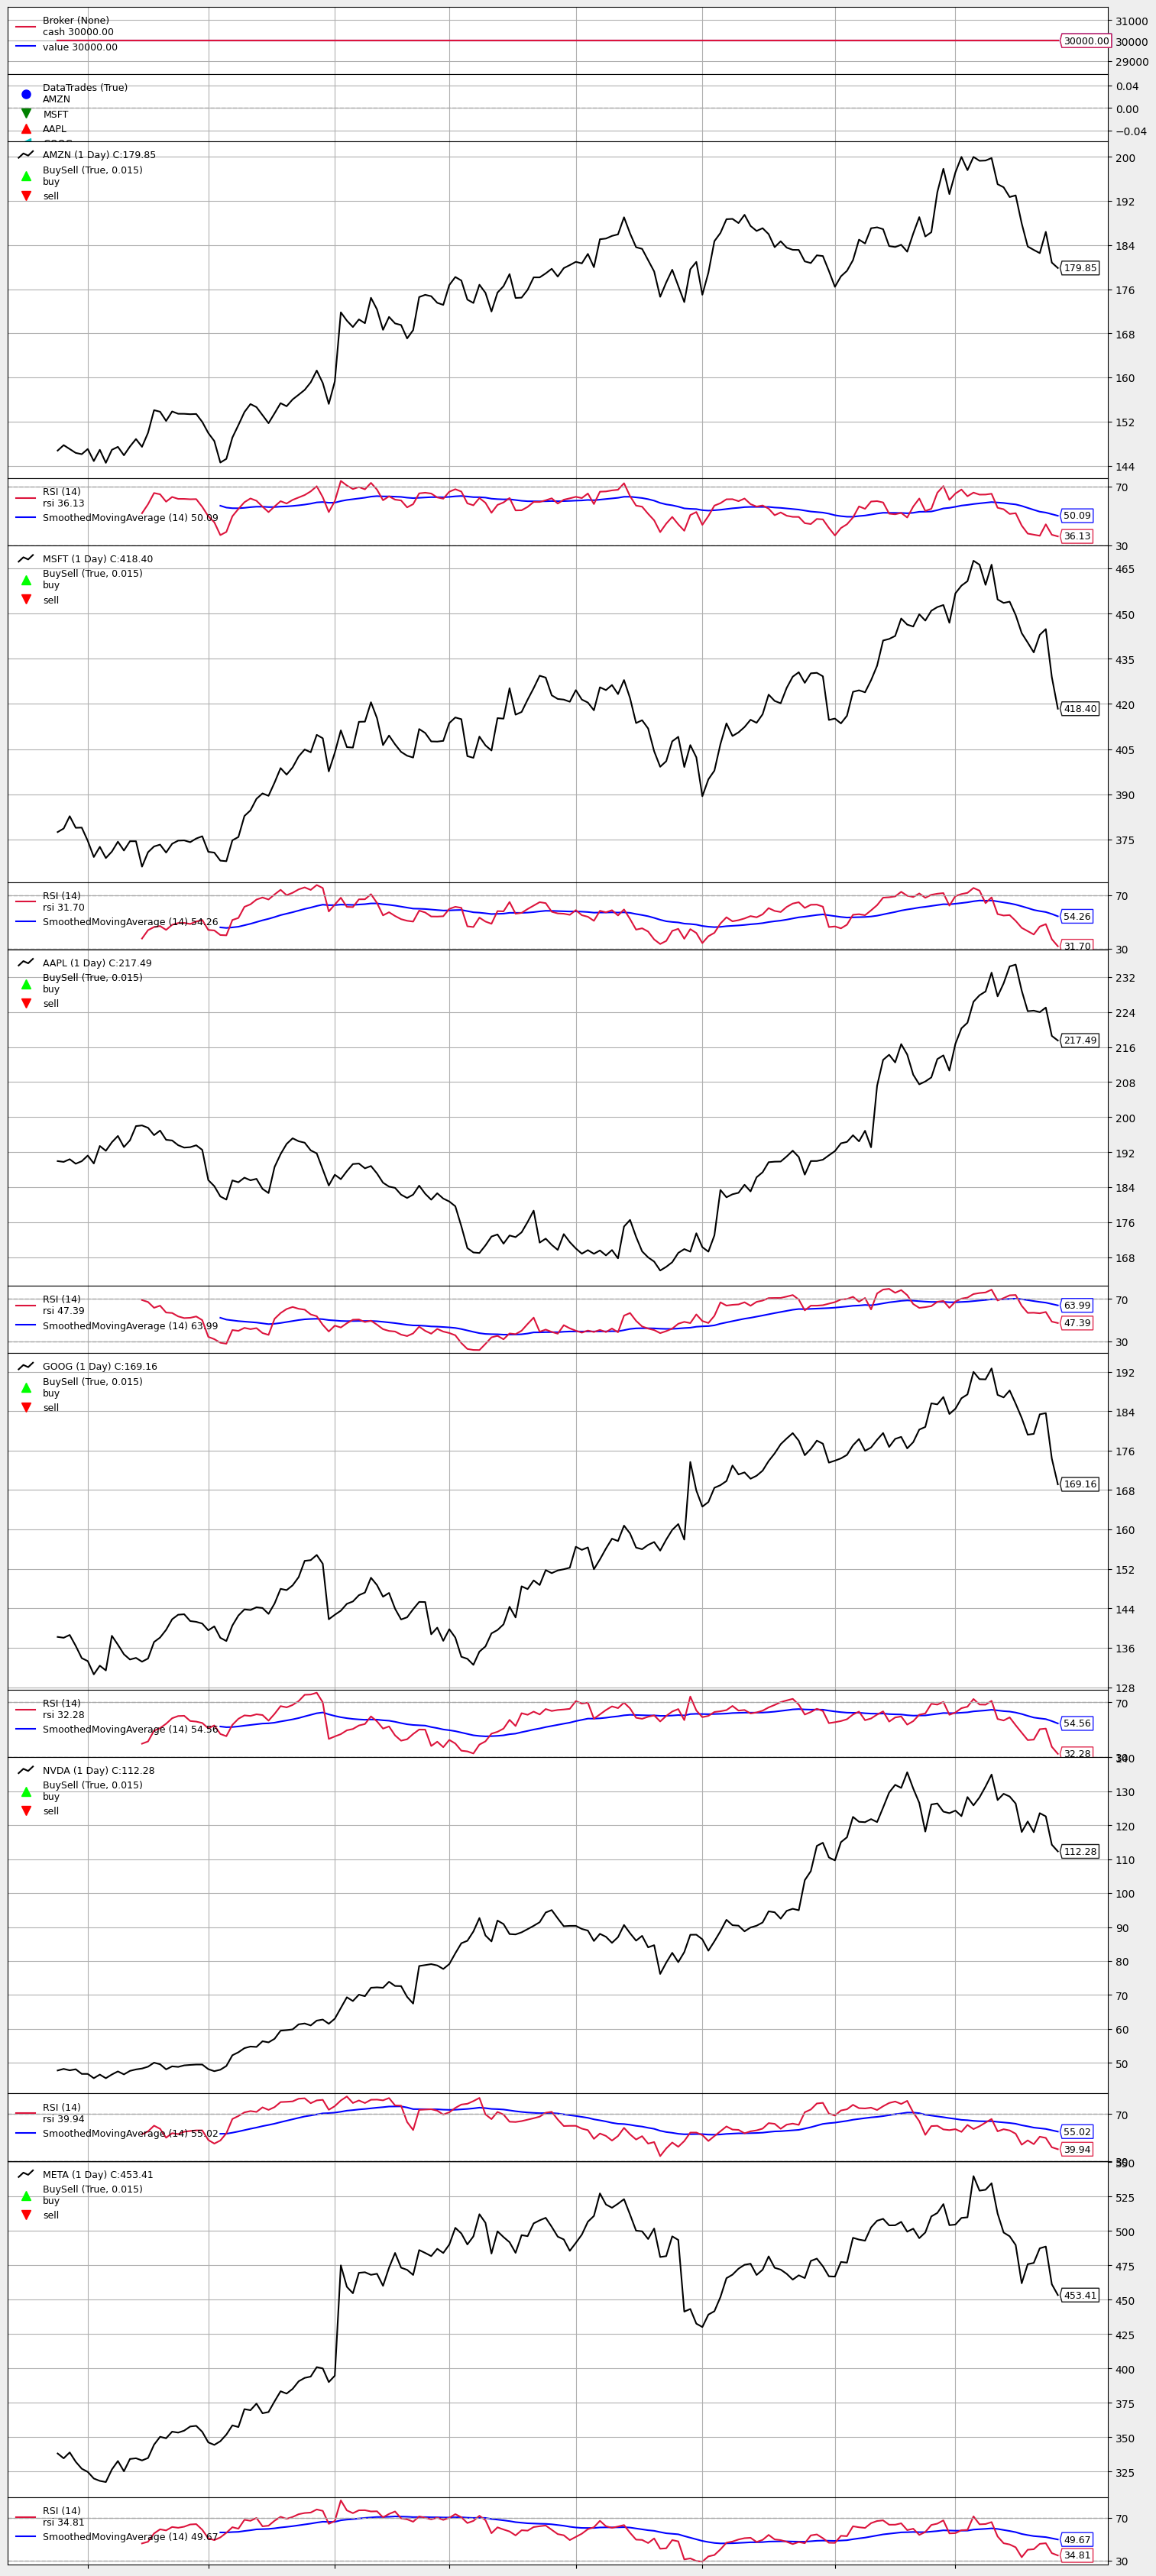

In [2]:
# FIXME: Move notebook to notebook folder and solve path issue
# Setup path
import sys, os
current_dir = os.getcwd()
src_path = os.path.join(current_dir, '..', 'src')
sys.path.append(os.path.abspath(src_path))
print(sys.path)

from services.backtesting_service import BacktraderStrategy

import datetime  # For datetime objects
import backtrader as bt
import backtrader.analyzers as btanalyzers
import yfinance as yf

optimise = False
initial_cash = 30000

# strategy-controls
printlog=True
upper_rsi=60
lower_rsi=50
loss_pct_threshold = 8
profit_protection_pct_threshold = 0
fixed_investment_amount=5000

tech_stock = [ 'AMZN', 'SNOW', 'MSFT', 'AAPL', 'GOOG', 'NVDA', 'META']
tech_stock_without_snow = [s for s in tech_stock if s != 'SNOW']
tech_stock_without_nvidia = [s for s in tech_stock if s != 'NVDA']
non_tech_stock = [ 'JNJ', 'JPM', 'PFE', 'PG', 'UNH', 'V'] # FIXME: default strategy causes losses in non-tech stock
interesting_stock = tech_stock_without_snow
#interesting_stock_without_nvda = interesting_stock.remove('NVDA')

num_years = 1
year_offset = 0
target_stock = tech_stock_without_snow

num_years_in_days = 365 * num_years
year_offset_in_days = 365 * year_offset

# default behaviour: last year tech stock
number_of_days_to_simulate, time_travel_days, tickers = num_years_in_days, year_offset_in_days, target_stock

# FIXME: len(self) is broken when SNOW is in ticker set
# FIXME: Hint 1: for 2-year-ago debug TestStrategy.days_in_buffer() shows 28 in AMZN, tech_stock_without_snow, but 297 with tech_stock
# FIXME: Hint 2: for year-to-date all show 28 meaning issue likely due to SNOW not being present 2 years prior 
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 2, ['AMZN']
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 2, tech_stock_without_snow
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 2, tech_stock
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 0, tech_stock_without_snow
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 0, tech_stock

end_date=datetime.datetime.today().date() - datetime.timedelta(time_travel_days)
start_date = end_date - datetime.timedelta(number_of_days_to_simulate + time_travel_days - BacktraderStrategy.RSI_WARMUP_IN_DAYS)

#start_date = datetime.datetime.strptime('2024-01-01', "%Y-%m-%d").date()
#end_date = datetime.datetime.strptime('2024-12-01', "%Y-%m-%d").date()

def add_stats(rsi_lower, rsi_upper, loss_pct, profit_protection_pct_threshold, fixed_investment_amount, final_value):
    stats.append({'rsi_lower': rsi_lower, 
                  'rsi_upper': rsi_upper, 
                  'loss_pct': loss_pct,
                  'profit_protection_pct_threshold': profit_protection_pct_threshold,
                  'fixed_investment_amount': fixed_investment_amount ,
                  'final_value': final_value}) 

def strategy_completed_callback(strategy):
    final_value = strategy.broker.get_value()
    print("strategy_completed_callback stats: " + 
        f'lower_rsi: {strategy.params.lower_rsi}, ' +
        f'upper_rsi: {strategy.params.upper_rsi}, ' +
        f'loss_pct: {strategy.params.loss_pct_threshold}, ' +
        f'profit_protection_pct_threshold: {strategy.params.profit_protection_pct_threshold}, ' +
        f'fixed_investment_amount: {strategy.params.fixed_investment_amount}, ' +
        f'final Portfolio Value: {final_value:.0f}'
    )
    stats.append({'rsi_lower': strategy.params.lower_rsi, 
        'rsi_upper': strategy.params.upper_rsi, 
        'loss_pct': strategy.params.loss_pct_threshold,
        'profit_protection_pct_threshold': strategy.params.profit_protection_pct_threshold,
        'fixed_investment_amount': strategy.params.fixed_investment_amount,
        'final_value': round(strategy.broker.getvalue())}) 

stats = []

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro(optreturn=False)

    if not optimise:
        # Add a strategy (see strategy-controls)
        cerebro.addstrategy(BacktraderStrategy,
                            printlog = printlog,
                            upper_rsi = upper_rsi,
                            lower_rsi = lower_rsi,
                            loss_pct_threshold = loss_pct_threshold,
                            profit_protection_pct_threshold = profit_protection_pct_threshold,
                            fixed_investment_amount = fixed_investment_amount)
    else:
        strats = cerebro.optstrategy(
            BacktraderStrategy,
            upper_rsi= 60 , # upper_rsi=range(55, 70, 5), RSI-upper down-crossing not wired
            lower_rsi = 40, # range(30, 60, 5), 
            loss_pct_threshold = 8, # range(1,15),
            profit_protection_pct_threshold = 0, #range(0, 100, 25),
            fixed_investment_amount = 5000, # range(500, 5500, 500),
            custom_callback=strategy_completed_callback,
            )
        cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

    print(f"time window = {start_date} .. {end_date}")

    # Add the Data Feed to Cerebro
    for ticker in tickers:
        data = bt.feeds.PandasData(dataname=yf.download(ticker, start_date, end_date))
        cerebro.adddata(data=data, name=ticker)

    # Set our desired cash start
    cerebro.broker.setcash(initial_cash)

    # Print out the starting conditions
    start_portfolio_value = cerebro.broker.getvalue()

    # Run over everything
    opt_runs = cerebro.run(maxcpus=1)
   
    if optimise: 
        print('Optimised runs by Final Value:')
        sorted_results = sorted(stats, key=lambda x: x['final_value'], reverse=True)
        for result in sorted_results[:5]:
            print(result)
    else:
        # Print out the final result
        print(f'Portfolio Value Starting: {start_portfolio_value:.0f}, End: {cerebro.broker.getvalue():.0f}')
        print(f'Plotting graphs ...')
        # Plot the result
        %matplotlib inline
        import matplotlib.pyplot as plt
        from pylab import rcParams #Creates parameters for our plot
        rcParams['figure.figsize'] = 16, 6 * len(tickers) #size
        rcParams['figure.facecolor'] = '#eeeeee' #Color scheme
        plt.plot() #The Plot Code
        plt.close()
        cerebro.plot(iplot=True, volume=False)